In [0]:
import zipfile
f = zipfile.ZipFile("drive/My Drive/additional/train.zip")
f.extractall("./datasets")

In [2]:
import glob
import pandas as pd
catfs = glob.glob("datasets/train/cat.*.[jJ][pP][gG]")
catans = [0] * len(catfs)
dogfs = glob.glob("datasets/train/dog.*.[jJ][pP][gG]")
dogans = [1] * len(dogfs)
df = pd.DataFrame({
    "path":catfs + dogfs,
    "target":catans + dogans
})
df

,path,target
0,datasets/train/cat.11630.jpg,0
1,datasets/train/cat.3765.jpg,0
2,datasets/train/cat.591.jpg,0
3,datasets/train/cat.6686.jpg,0
4,datasets/train/cat.2384.jpg,0
...,...,...
24995,datasets/train/dog.9502.jpg,1
24996,datasets/train/dog.10694.jpg,1
24997,datasets/train/dog.7585.jpg,1
24998,datasets/train/dog.1878.jpg,1


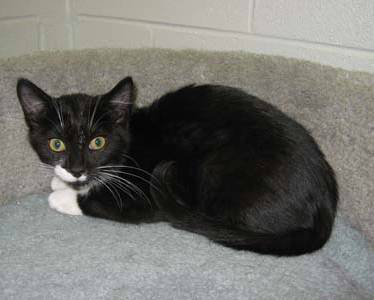

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing.image import load_img
idx = 1
load_img(df["path"][idx])

In [4]:
from tensorflow.keras.applications.vgg16 import VGG16
cnn = VGG16(include_top=False, input_shape=(224, 224, 3))
cnn.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization

for l in cnn.layers:
    # !!! trainable一定要先設置
    l.trainable = False
# 放在flatten後完全不對
x = BatchNormalization()(cnn.output)
x = Flatten()(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.25)(x)
out = Dense(2, activation="softmax")(x)
model = Model(inputs=cnn.input, outputs=out)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [0]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
model.compile(loss=SparseCategoricalCrossentropy(),
              optimizer="adam",
              metrics=["accuracy"])

In [0]:
# 訓練以前, 把所有的list, series.... -> nparray
import numpy as np
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(np.array(df["path"]),
                                                    np.array(df["target"]),
                                                    test_size=0.1)

In [0]:
# 請使用裡面的預處理(不要自己來)
from tensorflow.keras.applications.vgg16 import preprocess_input
# return: (原圖(batch), 處理後圖(batch), 答案(batch))
def dataflow(x, y, batch=20):
    idx = np.random.randint(0, x.shape[0], size=batch)
    x_batch, y_batch = x[idx], y[idx]
    x_ori, x_pre = [], []
    for fp in x_batch:
        img = load_img(fp, target_size=(224, 224))
        img_np = np.array(img)
        # 原本的圖片我存一份
        x_ori.append(img_np)
        img_pre = preprocess_input(img_np)
        # 預處理的圖片
        x_pre.append(img_pre)
    x_ori, x_pre = np.array(x_ori), np.array(x_pre)
    return (x_ori, x_pre, y_batch)

In [16]:
for i in range(20):
    print("-" * 10, i, "-" * 10)
    _, x, y = dataflow(x_train, y_train)
    result = model.train_on_batch(x, y)
    print("[Train]:", result)
    # 如果有時間的話, validate batch可以調高一點
    _, x, y = dataflow(x_test, y_test)
    result = model.test_on_batch(x, y)
    print("[Validate]:", result)

---------- 0 ----------
[Train]: [0.2855711579322815, 0.9681817889213562]
[Validate]: [0.05943257734179497, 0.949999988079071]
---------- 1 ----------
[Train]: [0.06836852431297302, 1.0]
[Validate]: [0.027834856882691383, 1.0]
---------- 2 ----------
[Train]: [0.10690070688724518, 0.949999988079071]
[Validate]: [0.31331920623779297, 0.949999988079071]
---------- 3 ----------
[Train]: [0.09807731211185455, 0.949999988079071]
[Validate]: [0.0024749357253313065, 1.0]
---------- 4 ----------
[Train]: [0.12817037105560303, 0.8999999761581421]
[Validate]: [0.09557535499334335, 0.8999999761581421]
---------- 5 ----------
[Train]: [0.03141891211271286, 1.0]
[Validate]: [0.0018303198739886284, 1.0]
---------- 6 ----------
[Train]: [0.7955764532089233, 0.8500000238418579]
[Validate]: [0.03797754645347595, 1.0]
---------- 7 ----------
[Train]: [0.025782454758882523, 1.0]
[Validate]: [0.026991600170731544, 1.0]
---------- 8 ----------
[Train]: [0.8306133151054382, 0.8999999761581421]
[Validate]: [

In [10]:
model.predict(x)

array([[1.0000000e+00, 1.1139774e-15],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [1.5928835e-37, 1.0000000e+00],
       [9.9696773e-01, 3.0322629e-03],
       [1.2564314e-05, 9.9998748e-01],
       [4.7958149e-18, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [7.1677922e-21, 1.0000000e+00],
       [1.0000000e+00, 3.1403942e-22],
       [1.3870347e-10, 1.0000000e+00],
       [2.2364890e-02, 9.7763515e-01],
       [2.9663309e-23, 1.0000000e+00],
       [1.0000000e+00, 1.2612047e-22],
       [1.0000000e+00, 1.1161517e-10],
       [3.3375499e-25, 1.0000000e+00],
       [1.0000000e+00, 4.7346120e-25],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [1.0000000e+00, 8.6468506e-13]], dtype=float32)

In [25]:
timg, tx, ty = dataflow(x_test, y_test, 500)
model.evaluate(tx, ty)

16/16 [==============================] - 2s 132ms/step - loss: 0.3520 - accuracy: 0.9580


[0.3520006239414215, 0.9580000042915344]

In [30]:
# predict_classes: Model沒有
# predict + argmax = predict_classes
# argmax: 幫你找到最小值的index(axis=-1 == axis=1)
pre = model.predict(tx).argmax(axis=-1)
pre

array([0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0,
       1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0,

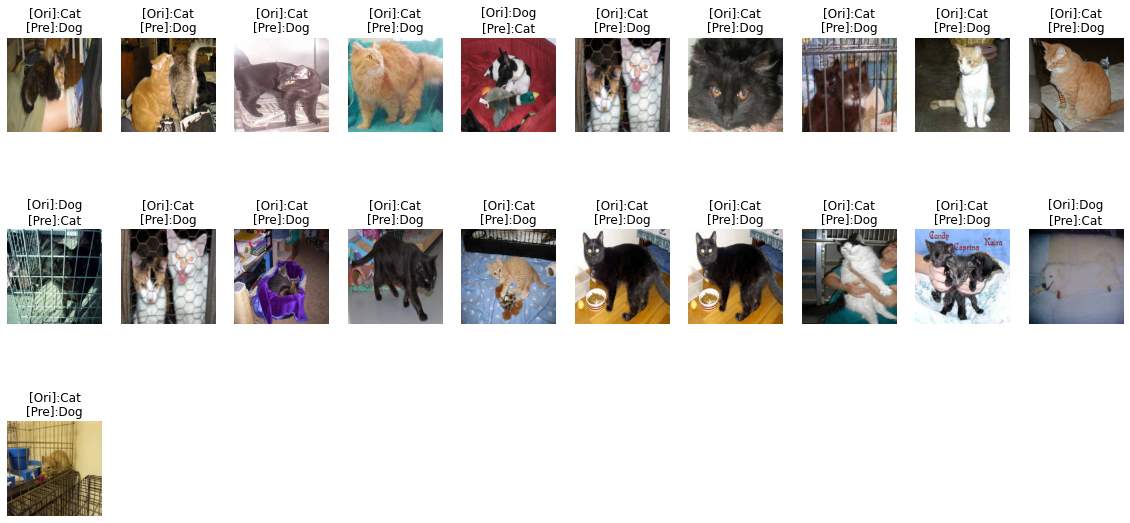

In [31]:
# nonzero: 取出是True的index
# (x座標, y座標, z座標)
trans = ["Cat", "Dog"]
idx = np.nonzero(pre != ty)[0]
# 預測錯誤的圖
false_img = timg[idx]
false_answer = ty[idx]
false_predict = pre[idx]

# 把圖變大一點才塞的下
plt.figure(figsize=(20, 10))
width = 10
height = len(false_img) // width + 1
for i, img in enumerate(false_img):
    plt.subplot(height, width, i+1)
    plt.axis("off")
    t = "[Ori]:{}\n[Pre]:{}".format(trans[false_answer[i]],
                                    trans[false_predict[i]])
    plt.title(t)
    plt.imshow(img)